# Tesla Stock Price Forecast

In [1]:
import pandas as pd
import quandl
import math, datetime
import numpy as np
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

style.use("ggplot")

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Regression, typically used for forecast. This wont make you rich!

In [2]:
# Collecting Data
df = quandl.get("WIKI/TSLA")

df = df[["Adj. Open", "Adj. High", "Adj. Low", "Adj. Close", "Adj. Volume"]]
df["HL_PCT"] = (df["Adj. High"] - df["Adj. Close"]) / df["Adj. Close"] * 100.0  # PCT - percent
df["PCT_change"] = (df["Adj. Close"] - df["Adj. Open"]) / df["Adj. Open"] * 100.0
df = df[["Adj. Close", "HL_PCT", "PCT_change", "Adj. Volume"]]

df.fillna(-9999, inplace=True)  # Fills the not a number with -99999, resulting an outlier
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2017-07-06,308.89,3.852472,-2.638215,19189195.0
2017-07-07,313.22,1.206819,-0.089314,14053750.0
2017-07-10,316.05,0.598007,1.006711,13702080.0
2017-07-11,327.22,0.018336,3.550633,11400054.0
2017-07-12,329.52,1.086429,-0.266344,10297839.0


In [3]:
# Features and Labels
forecast_col = "Adj. Close"
forecast_out = int(math.ceil(0.01 * len(df)))  # 1% of the frame.
print("Forecast for %d days" %forecast_out)

df["label"] = df[forecast_col].shift(-forecast_out)

df.tail()

Forecast for 18 days


,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2017-07-06,308.89,3.852472,-2.638215,19189195.0,NaN
2017-07-07,313.22,1.206819,-0.089314,14053750.0,NaN
2017-07-10,316.05,0.598007,1.006711,13702080.0,NaN
2017-07-11,327.22,0.018336,3.550633,11400054.0,NaN
2017-07-12,329.52,1.086429,-0.266344,10297839.0,NaN


In [4]:
X = np.array(df.drop(["label"], 1))
X = preprocessing.scale(X)  # Adds processing time
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df["label"])

In [6]:
# Training and Testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3)
clf = LinearRegression(n_jobs=-1)  # Classifier
clf.fit(X_train, y_train)

# Saving the Classifier
# with open("linearregression.pickle", "wb") as f:
#     pickle.dump(clf, f)

# pickle_in = open("linearregression.pickle", "rb")
# clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test)
print("Accuracy: %s" %accuracy)  # square error

Accuracy: 0.956096808979


In [7]:
# Forecasting and Predicting
forecast_set = clf.predict(X_lately)
print("Forecast for the next %s days:\n" %forecast_out, forecast_set, "\nAccuracy:", accuracy)

Forecast for the next 18 days:
 [ 370.62060942  368.99107404  372.08568705  374.58979251  382.07970394
  382.10055524  376.62714019  361.82426875  370.32051922  361.38694086
  360.49022809  351.45516234  334.23878416  318.33648109  319.32398513
  321.78051117  330.43326861  332.58922263] 
Accuracy: 0.956096808979


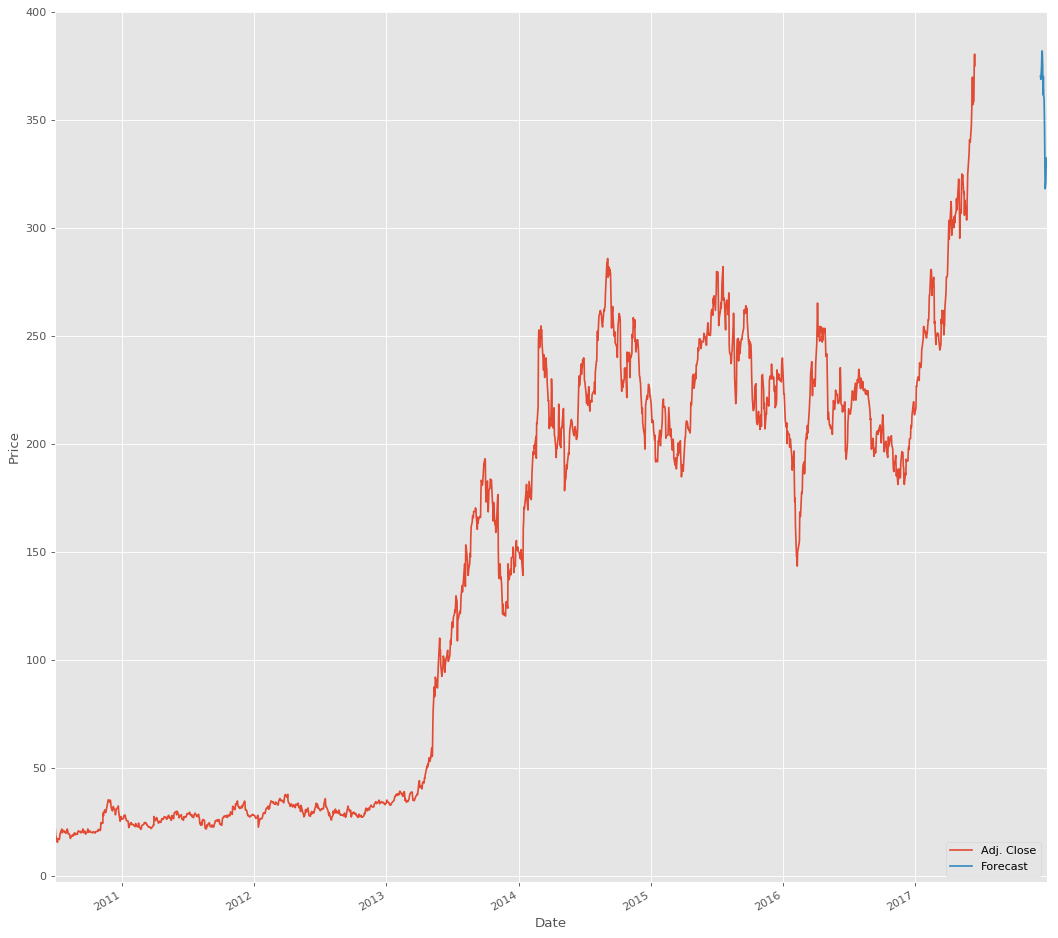

In [18]:
df["Forecast"] = np.nan  # Specify that the column is not a number
last_date = df.iloc[-1].name 
last_unix = last_date.timestamp()
one_day = 86400  # Seconds in a day
next_unix = last_unix + one_day
for i in forecast_set:
    # Making the future features NaN
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]  # The index of the dataframe
    
plt.figure(figsize=(16, 16), dpi= 100)
df["Adj. Close"].plot()
df["Forecast"].plot()
plt.legend(loc=4)  # Putting it on the bottom right
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()